# Benchmark algorithm for isomorphism of OA's

#### Scheme

As in "Classifier":
 - Generate one OA to test against
 -  generate a dataset of OA's, balanced 50% iso and 50% non-iso
 - measure the performance of the algorithm
 - Test against the computational complexity of other (exact) approaches
    

### Remarks:
As per the theory, it only makes sense to use **switch** isomorphisms, so at most there are $2^d$ isomorphs of each array. It makes no sense to use "sampleChildren" larger than this

### Complexity Comparison

We are now sure that the normal form of on OA gives a unique representative of its iso class. It is computed by the LMC test (lexicographically minimum by columns), described in Schoen, Eendebak, Nguyen (2009). Its complexity is not straightforward, but we could estimate that for the positive case (array is minimal) it is of the same order as $d! 2^2$. It is implemented in the `oapackage` library as `reduceLMCform( arr )`.

Our test has a tunable complexity, so in case the exact complexity is impractical, we could still provide as answer with a certain amount of confidence. We can showcase it by describing the accuracy curve as a function of complexity (% of correct guesses as a function of how many loop iterations). Notice we do at most $2^d$ iterations (number of switch isomorphisms) (in fact we could remove one as we do not use the identity). 

One goal would be to identify whether the exact complexity is greater or smaller than $2^d$. The other one would be to idenify if, for example, the 50-50 threshold (which is equivalent to chance for a binary test) sits at a sufficiently small fraction of the complexity of the exact test. 

Imports

In [1]:
import os
import os.path

import numpy as np
from statistics.pmf import PMF
from statistics.OA import OA, genOA, genFiltrations
from statistics.OAIso import allIsomorphisms, allSwitchIsomorphisms
from persistence.pers import compute_perm_classes, persistencePairs, WasDistances, BotDistances, Was1DDistances, DistancesDistr
from persistence.distances import wasserstein2DNoDiag, wasserstein1D

#These are not necessary
#from geometry.polytope import Polytope, computePolytope
#from geometry.polytope import conditionsOA3, conditionsOA4, conditionsOA5

import random

from math import floor, ceil
import matplotlib.pyplot as plt
import pandas as pd

### Parameters

In [2]:
N = 24 # number of runs
d = 5 # number of factors

# How many isomorphs to sample for data generation
sampleChildren = 500
sampleChildren = 32

# How many isomorphs to sample for the test
loop = 500


### Generation of the data

In [208]:
def genDatasetOA(N,d, size, options=None, Perms=None):
    '''Function to generate a dataset of OA on which to run the classification algorithm
    
    INPUT:
    - N: (int) number of runs
    - d: (int) dimension
    - size: (int) number of arrays to generate 
    - Perms (numpy matrix) a precomputed matrix of isomorphisms with 2**d rows and as many columns as there are iso
    
    - options: (dict) The following keys are specified:
    -  Isomorphs_Type: (string) if 'switch' use only switches to generate isomorphs of the arrays given by genOA.
    If 'all' use both switch and permutations. If anything else, raise an error. Default to all. IF 
    - Ratio: (float) number of isomorphs to number of non-iso in the data, x to 1. Default is 1, that is 50-50
    - WhichClass: (string) if 'random', shuffle randomly the iso-classes of OA's returned by oapackage. The test array 
    will be drawn by the first class after the shuffle. If (int) an int from 1 to the number of classes, pick that as
    the test array class
    - Original: (bool) if True, use the exact array returned by oapackage as the representative of the chosen class.
    If False, use some array in the class but not necessarily that one. Default True.
    - ShuffleOutput: wheter to shuffle the output lists. Defaults to False.
    - Verbose: If True, print info. Defaults to True

    OUTPUT:
    - a single OA to test against (numpy array of the pmf)
    - a list of arrays (as numpy arrays representing the pmf's)
    - a list of labels (True if isomorphic, False if not)
    '''
    
    # process parameters in options
    
    if options is None:
        options = {}
        
    # check no wrong keys
    if not set(options.keys()).issubset( set(['Isomorphs_Type','Ratio','WhichClass','Original','ShuffleOutput','Verbose'])):
        
        raise ValueError('There are wrong keys in the options dict')
   
    if Perms is not None:
        #if not isinstance(Perms, type(np.array)):
            #raise ValueError('Perms must be a numpy array')
            
        if Perms.shape[0] != 2**d:
            raise ValueError('Wrong dimensions in Perms')
    try:
        iso_type = options['Isomorphs_Type']
            
    except KeyError:
        iso_type = 'all'
        
    if iso_type == 'switch':
        if Perms is None:
            perms = allSwitchIsomorphisms(d)
        else:
            perms = Perms
    elif iso_type == 'all':
        if Perms is None:
            perms = allIsomorphisms(d)
        else:
            perms = Perms
    else:
        raise ValueError('Undefined isomorphs type')
        
    try:
        ratio = options['Ratio']
        
        if isinstance(ratio, int):
            ratio = float(ratio)
        elif isinstance(ratio, float):
            pass
        else: # check it is a numeric value
            raise ValueError('Ratio must be a float value')
        
    except KeyError:
        ratio = 1.0
        
    try:
        which_class = options['WhichClass']
    
    except KeyError:
        which_class = 'random'
        
    if type(which_class) == int:
        pass
    elif which_class == 'random':
        pass
    else:
        raise ValueError('Invalid WhichClass (choice of test array)')
        
    try:
        original = options['Original']
        if type(original) is not bool:
            raise ValueError('Original has to be boolean')
        
    except KeyError:
        original = True
        
    try:
        shuffleOutput = options['ShuffleOutput']
        
        if not isinstance(shuffleOutput, bool):
            raise ValueError('ShuffleOutput must be a bool')
            
    except KeyError:
        shuffleOutput = False
        
    try:
        verbose = options['Verbose']
        if not isinstance(verbose, bool):
            raise ValueError('Verbose must be a bool')
            
    except KeyError:
        verbose = True
           
        
    # The set of isomorphisms is generated, now on to generate OA's
    
    oas , _ , _ = genOA(N,d)
    
    NOas = len(oas)
    
    # shuffle or select test class
    if which_class == 'random':
        random.shuffle(oas)
        
    else: # it's an int
        # swap the first with this value
        tmp = oas[0]
        oas[0] = oas[which_class]
        oas[which_class] = tmp
        del tmp
        
    N_Iso = (ratio/(ratio+1))*size # number of iso
    N_NIso = (1/(ratio+1))*size # number of non-iso
    
    if N_Iso - floor(N_Iso) <= .5:
        
        N_Iso = floor(N_Iso)
        N_NIso = ceil(N_NIso)
    else:

        N_Iso = ceil(N_Iso)
        N_NIso = floor(N_NIso)
        
    assert N_Iso + N_NIso == size
    
    # check that the size of the isomorphism classes is enough 
    # to extract N_Iso arrays without repeating
    NofIso = perms.shape[1]
    
    if NofIso - 1 < N_Iso: # -1 because one is the identity
        
        print('WARNING! There are not enough isomorphisms for the required size')
        print('Size ', size, ' with ratio ', ratio, ' means ', N_Iso, ' arrays from the test class')
        print(f"However, with {'only switch' if iso_type=='switch' else iso_type} isomorphisms, only {NofIso} exist.")
        print('There will be duplicates in the iso class')
        
    # generate test array
    
    test_array = oas[0].to_pmf(normalize=True).values
    
    if not original:
        
        randomPerm = np.random.choice( NofIso )
        test_array = test_array[ perms[: , randomPerm]]
        
    # generate dataset of arrays
    
    Isomorphs = []
    NIsomorphs = []
        
    # SAMPLE random isomorphs
    try:
        samplePerms = np.random.choice( NofIso , (N_Iso,) , replace=False)
        
    except ValueError: # means replace is false but N_Iso > NofIso (so a fortiori > NofIso - 1)
        samplePerms = np.random.choice( NofIso , (N_Iso,) , replace=True)
        
    pmf = oas[0].to_pmf(normalize=True).values # starting pmf
    for i in samplePerms: # for each of the N_Iso chosen isomorphic arrays
        
        Isomorphs.append( pmf[ perms[: , i]] ) # apply the isomorphism and append this new array to the dataset
     
    # now sample the non-isomorphs: try to be uniform among non-iso classes
    NPerClass = floor(N_NIso / (NOas - 1))
    
    # plus the rest needed
    NLeftover = N_NIso - NPerClass * (NOas - 1)
    
    # sample quasi-uniformly
    for j in range(1, NOas):
        pmf = oas[j].to_pmf(normalize=True).values # starting pmf
        
        # sample isomorphisms
        try:
            samplePerms = np.random.choice( NofIso , (NPerClass,) , replace=False)

        except ValueError: # means replace is false but NPerClass > NofIso
            samplePerms = np.random.choice( NofIso , (NPerClass,) , replace=True)
        
        # apply isomorphisms
        for i in samplePerms: # for each of the N_Iso chosen isomorphic arrays
        
            NIsomorphs.append( pmf[ perms[: , i]] ) # apply the isomorphism and append this new array to the dataset
     
      # if there is leftover, add it
    for j in range(NLeftover):
        
        # choose a class
        randomClass = np.random.choice( NOas - 1 ) + 1 # shift by one (we use only the non-iso)
        
        pmf = oas[randomClass].to_pmf(normalize=True).values # starting pmf
        randomPerm = np.random.choice( NofIso ) # pick a random isomorphism
        NIsomorphs.append( pmf[ perms[: , randomPerm]] ) # apply it
    
    # output
    
    data = Isomorphs + NIsomorphs
    
    labels = [True]*len(Isomorphs) + [False]*len(NIsomorphs)
    
    if shuffleOutput:
        
        output = list(zip(data, labels))
        random.shuffle(output)
        
        data = [x[0] for x in output]
        labels = [x[1] for x in output]
    
    #Summary
    if verbose:
        print('\n**')
        print(f"Data generated with size {size}. First there are {N_Iso} isomorphs and then {N_NIso} non-isomorphs.")
        print(f"Using {'only switch' if iso_type=='switch' else iso_type} isomorphisms, which are {NofIso}")
    
    return test_array, data, labels

In [4]:
options = {'WhichClass':'random', 'Ratio':1, 'Isomorphs_Type':'all', 'ShuffleOutput':True}

In [5]:
test, data, labels = genDatasetOA(N=20, d=4, size=500, options=None)


**
Data generated with size 500. First there are 250 isomorphs and then 250 non-isomorphs.
Using all isomorphisms, which are 384


### Classification Algorithm

In [155]:
def isomorphismCheck( p1 , p2, d, loop, switchPerms, EPS= 1E-7 ):
    ''' Function that implements the classification algorithm
    
    Takes two pmf's as inputs, returns either True or False
    INPUT: 
    - p1 numpy array of the first normalized pmf
    - p2 numpy array of the second normalized pmf
    - d: (int) dimension
    - loop: (int) how many iterations
    - switchPerms: numpy matrix of switch permutations to apply (precompute with allSwitchIsomorphisms)
    - EPS: (float) a tolerance for checking if a distance is zero
    
    OUTPUT:
    - True or False (response of the isomorphism test)

    '''
    
    # Compute 1d Wasserstein between pmf's
    Was1P = wasserstein1D( p1 , p2 )

    Was1F = None

    Was2D = None

    if Was1P > EPS: # if not zero, they are guaranteed to be non-isomorphic

        return False

    # otherwise begin the loop
    # choose the permutations to apply
    
    NPerms = switchPerms.shape[1]
    try:
        samplePerms = np.random.choice(NPerms, (loop,), replace = False)
    except ValueError: # replace is True but loop > NPerms
        print('Warning: sampling with repeats in IsoTest as loop > number of available permutations')
        samplePerms = np.random.choice(NPerms, (loop,), replace = True)

    Pmf1 = PMF(d,p1) # pmf object
    filt1 = Pmf1.compute_filtration() #compute filtration

    pp1 = persistencePairs(filt1, d) # compute pairs
    pp1 = pp1[1] # only value pairs, not the integers
    
    newp2 = p2.copy()

    for j in range(loop):
        # create pmf objects
        
        i = samplePerms[j] # choose the permutation for the next step

        Pmf2 = PMF(d,newp2)
        filt2 = Pmf2.compute_filtration()

        Was1F = wasserstein1D( filt1 , filt2 )

        if Was1F > EPS: # filtration distance is positive, no need to perform 2D

            # choose a random isomorphism
            #randInt = np.random.randint(switchPerms.shape[1])

            newp2 = p2[switchPerms[:,i]] # apply the isomorphism
            
            continue # next iteration in the loop

        # If instead Was1F == 0, compute Was2D
        
        pp2 = persistencePairs(filt2, d) # compute pairs
        pp2 = pp2[1] # only value pairs, not the integers

        Was2D = wasserstein2DNoDiag( pp1, pp2 )
        

        if Was2D <= EPS: # If this distance is zero, we guess they are isomorphic

            return True
        
        # Instead, if D2 is NOT zero, we keep on searching

        # choose a random isomorphism
        #randInt = np.random.randint(switchPerms.shape[1])

        newp2 = p2[switchPerms[:,i]] # apply the isomorphism
        
        # and pass to the next loop iteration


    # if you get to the end of the loop without ever finding zero, we guess they are not isomorphic   
    
    return False

### Parameters

In [134]:
N = 24
d = 5
size = 200

#### Generate data

In [135]:
options = {'WhichClass':'random', 'Ratio':1, 'Isomorphs_Type':'all', 'ShuffleOutput':False, 'Original':False}
testArray, data, labels = genDatasetOA(N, d, size, options)


**
Data generated with size 200. First there are 100 isomorphs and then 100 non-isomorphs.
Using all isomorphisms, which are 3840


#### Pre-compute all switch permutations

In [9]:
switchPerms = allSwitchIsomorphisms(d)

#### Set up algorithm

In [74]:
# Length of loop
loop_length = 50

testIso = lambda p: isomorphismCheck(testArray, p, d, loop_length, switchPerms)

### Run

In [75]:
results = [ testIso(p) for p in data ]

### Scoring

In [25]:
def scoring(results, labels):
    
    truePos = trueNeg = falsePos = falseNeg = 0
    
    for r,l in zip(results, labels):
        if l:
            if r:
                truePos += 1
            else:
                falseNeg += 1
        else:
            if r:
                falsePos += 1
            else:
                trueNeg += 1
                
    return truePos, trueNeg, falsePos, falseNeg

#Score
print('       * SCORING * ', flush=True)
print('')

truePos, trueNeg, falsePos, falseNeg = scoring(results, labels)

print('          Pred  ')
print('       Pos   Neg' )
print('    Pos ', truePos, ' ',  falseNeg)
print('True')
print('    Neg ', falsePos, ' ',  trueNeg)
print(' ')

       * SCORING * 

          Pred  
       Pos   Neg
    Pos  22   78
True
    Neg  0   100
 


#### Metrics

In [26]:
def metrics(truePos, trueNeg, falsePos, falseNeg):

    accuracy = np.float64(truePos + trueNeg) / (truePos+falsePos+trueNeg+falseNeg)
    precision = np.float64(truePos) / (truePos+falsePos)
    recall =  np.float64(truePos) / (truePos + falseNeg)
    F1 = 2*(precision*recall)/(precision+recall)
    
    return accuracy,precision,recall,F1

accuracy,precision,recall,F1 = metrics(truePos, trueNeg, falsePos, falseNeg)

In [27]:
print('Accuracy', accuracy)
print('Precision', precision)
print('Recall', recall)
print('F1 score', F1)

Accuracy 0.61
Precision 1.0
Recall 0.22
F1 score 0.36065573770491804


## Test the algorithm at different loop lengths

Dimension parameters

In [217]:
N = 20
d = 6
size = 200

Test parameters 

How many iterations for each parameter point?
Which eps?

In [218]:
repeats = 5
eps = 1E-5

Store the performance results

In [219]:
AAcc = []
APrec = []
ARec = []
AF1s = []

Generate the loop length steps

In [221]:
loopLengths = np.linspace(1,2**d, num=6, dtype=int).tolist()

loopLengths

[1, 13, 26, 38, 51, 64]

Precompute switch isomorphisms

In [200]:
switchPerms = allSwitchIsomorphisms(d)

In [193]:
allPerms = allIsomorphisms(d)

In [194]:
allPerms.shape

(64, 46080)

Use a sample to mix some permutations into the switches

In [22]:
sample = np.random.choice(allPerms.shape[1], (2**d,))

Perms = np.column_stack([switchPerms, allPerms[:,sample]])


### Run the cycle

In [222]:
for loop in loopLengths:
    
    Accs, Precs, Recs, F1s = [],[],[],[]
    
    print('Loop parameter ',loop, flush=True)
    
    for r in range(repeats):
        
        print('  Iteration ', r+1, ' of ', repeats, flush=True)
        
        # generate data
        options = {'WhichClass':'random', 'Ratio':1, 'Isomorphs_Type':'all', \
                   'ShuffleOutput':False, 'Verbose':False, 'Original':False}
        testArray, data, labels = genDatasetOA(N, d, size, options, Perms=allPerms)
        
        # define the test with appropriate length
        testIso = lambda p: isomorphismCheck(testArray, p, d, loop, switchPerms, EPS=eps)
        
        # run the test
        results = [ testIso(p) for p in data ]
        
        # compute scores
        acc, prec, rec, f1 = metrics(*scoring(results,labels))
        
        Accs.append(acc)
        Precs.append(prec)
        Recs.append(rec)
        F1s.append(f1)
        
    AAcc.append(Accs)
    APrec.append(Precs)
    ARec.append(Recs)
    AF1s.append(F1s)
    
        

Loop parameter  1
  Iteration  1  of  5
  Iteration  2  of  5


/tmp/ipykernel_5042/3999208988.py:4: RuntimeWarning: invalid value encountered in scalar divide
  precision = np.float64(truePos) / (truePos+falsePos)


  Iteration  3  of  5
  Iteration  4  of  5
  Iteration  5  of  5
Loop parameter  13
  Iteration  1  of  5
  Iteration  2  of  5
  Iteration  3  of  5
  Iteration  4  of  5
  Iteration  5  of  5
Loop parameter  26
  Iteration  1  of  5
  Iteration  2  of  5
  Iteration  3  of  5
  Iteration  4  of  5
  Iteration  5  of  5
Loop parameter  38
  Iteration  1  of  5
  Iteration  2  of  5
  Iteration  3  of  5
  Iteration  4  of  5
  Iteration  5  of  5
Loop parameter  51
  Iteration  1  of  5
  Iteration  2  of  5
  Iteration  3  of  5
  Iteration  4  of  5
  Iteration  5  of  5
Loop parameter  64
  Iteration  1  of  5
  Iteration  2  of  5
  Iteration  3  of  5
  Iteration  4  of  5
  Iteration  5  of  5


In [223]:
loopLengths

[1, 13, 26, 38, 51, 64]

## Plot results

In [224]:
AccMeans = [np.nanmean(elem) for elem in AAcc]
APrecMeans = [np.nanmean(elem) for elem in APrec]
ARecMeans = [np.nanmean(elem) for elem in ARec]
AF1sMeans = [np.nanmean(elem) for elem in AF1s]

In [31]:
AccMeans = [np.nan_to_num(elem) for elem in AccMeans]
APrecMeans = [np.nan_to_num(elem) for elem in APrecMeans]
ARecMeans = [np.nan_to_num(elem) for elem in ARecMeans]
AF1sMeans = [np.nan_to_num(elem) for elem in AF1sMeans]

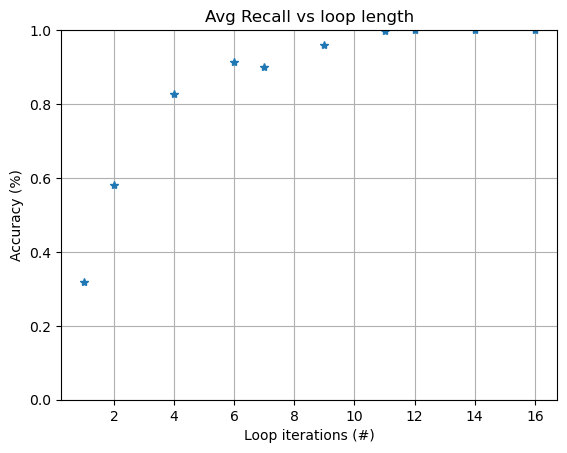

In [164]:
plt.plot(loopLengths, ARecMeans, '*')
plt.grid()
plt.title('Avg Recall vs loop length');
plt.xlabel('Loop iterations (#)')
plt.ylabel('Accuracy (%)')
plt.ylim(0.0,1.0);

#### 

In [129]:
ARec

[[1.0, 0.89, 1.0, 1.0, 1.0, 1.0, 0.99, 1.0, 1.0, 1.0]]

In [130]:
APrec

[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]]

## Plot metrics averages

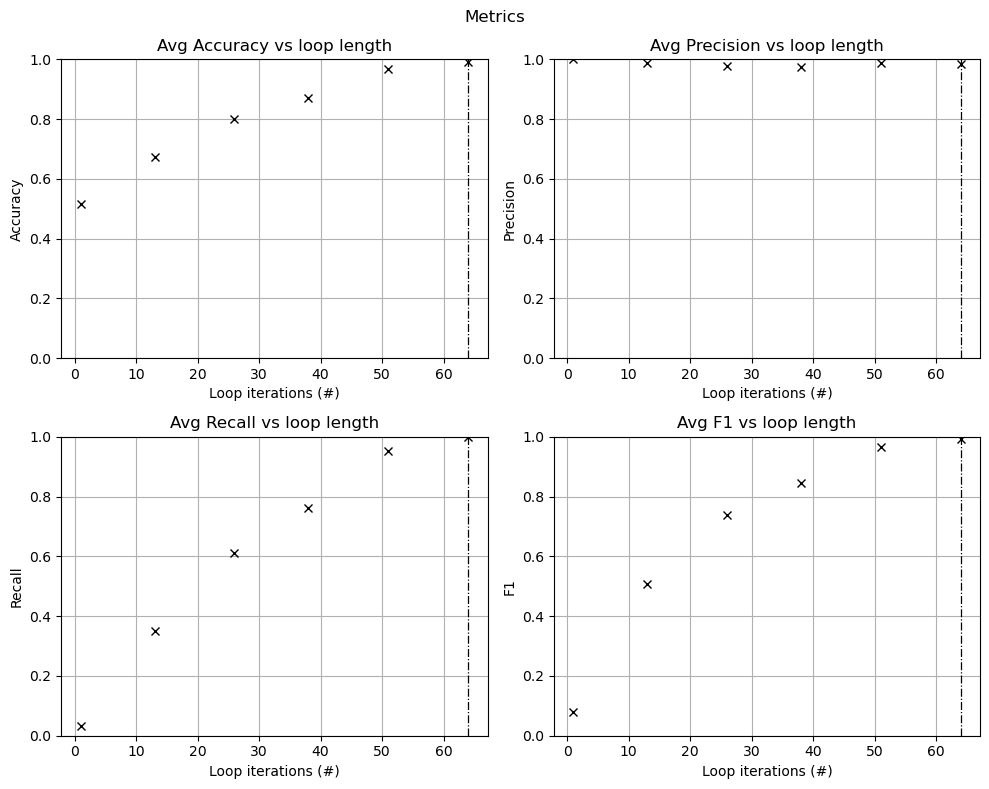

In [225]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))  
fig.suptitle('Metrics')


axs[0, 0].set_title('Avg Accuracy vs loop length')
axs[0, 0].plot(loopLengths, AccMeans, 'kx') 
axs[0,0].grid()
axs[0,0].axvline(x=2**d, color='k', linestyle='-.', linewidth=.9)
axs[0,0].set_xlabel('Loop iterations (#)')
axs[0,0].set_ylabel('Accuracy')
axs[0,0].set_ylim(0.0,1.0);

axs[0, 1].set_title('Avg Precision vs loop length')
axs[0, 1].plot(loopLengths, APrecMeans, 'kx') 
axs[0, 1].grid()
axs[0,1].axvline(x=2**d, color='k', linestyle='-.', linewidth=.9)
axs[0,1].set_xlabel('Loop iterations (#)')
axs[0,1].set_ylabel('Precision')
axs[0,1].set_ylim(0.0,1.0);


axs[1, 0].set_title('Avg Recall vs loop length')
axs[1, 0].plot(loopLengths, ARecMeans, 'kx')
axs[1, 0].grid()
axs[1,0].axvline(x=2**d, color='k', linestyle='-.', linewidth=.9)
axs[1,0].set_xlabel('Loop iterations (#)')
axs[1,0].set_ylabel('Recall')
axs[1,0].set_ylim(0.0,1.0);

axs[1, 1].set_title('Avg F1 vs loop length')
axs[1, 1].plot(loopLengths, AF1sMeans, 'kx')
axs[1, 1].grid()
axs[1,1].axvline(x=2**d, color='k', linestyle='-.', linewidth=.9)
axs[1,1].set_xlabel('Loop iterations (#)')
axs[1,1].set_ylabel('F1')
axs[1,1].set_ylim(0.0,1.0);


plt.tight_layout()

## Plot metrics points

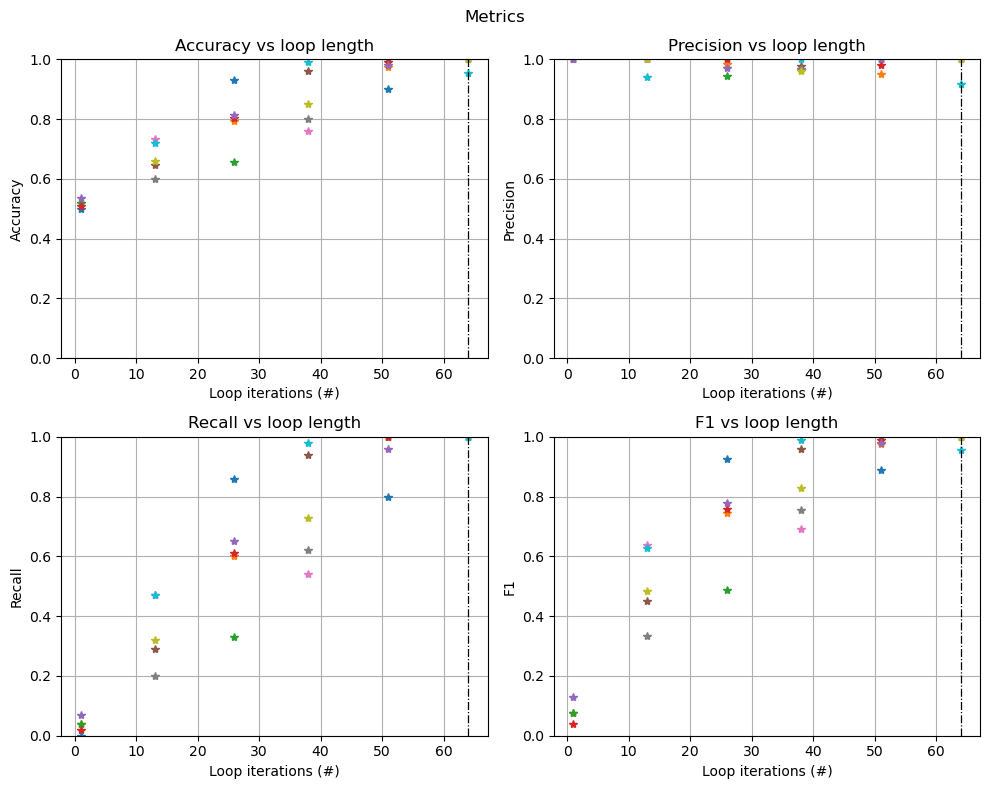

In [226]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))  # Adjust figsize as needed
fig.suptitle('Metrics')

# Access each subplot by indexing
axs[0, 0].set_title('Accuracy vs loop length')
for i,l in enumerate(loopLengths):
    for vals in AAcc[i]:
        axs[0, 0].plot(l, vals, '*') 
axs[0,0].grid()
axs[0,0].axvline(x=2**d, color='k', linestyle='-.', linewidth=.9)
axs[0,0].set_xlabel('Loop iterations (#)')
axs[0,0].set_ylabel('Accuracy')
axs[0,0].set_ylim(0.0,1.0);

axs[0, 1].set_title('Precision vs loop length')
for i,l in enumerate(loopLengths):
    for vals in APrec[i]:
        axs[0, 1].plot(l, vals, '*') 

axs[0, 1].grid()
axs[0,1].axvline(x=2**d, color='k', linestyle='-.', linewidth=.9)
axs[0,1].set_xlabel('Loop iterations (#)')
axs[0,1].set_ylabel('Precision')
axs[0,1].set_ylim(0.0,1.0);


axs[1, 0].set_title('Recall vs loop length')
for i,l in enumerate(loopLengths):
    for vals in ARec[i]:
        axs[1, 0].plot(l, vals, '*')       
axs[1,0].grid()
axs[1,0].axvline(x=2**d, color='k', linestyle='-.', linewidth=.9)
axs[1,0].set_xlabel('Loop iterations (#)')
axs[1,0].set_ylabel('Recall')
axs[1,0].set_ylim(0.0,1.0);

axs[1, 1].set_title('F1 vs loop length')
for i,l in enumerate(loopLengths):
    for vals in AF1s[i]:
        axs[1, 1].plot(l, vals, '*') 
axs[1, 1].grid()
axs[1,1].axvline(x=2**d, color='k', linestyle='-.', linewidth=.9)
axs[1,1].set_xlabel('Loop iterations (#)')
axs[1,1].set_ylabel('F1')
axs[1,1].set_ylim(0.0,1.0);


plt.tight_layout()

## Try Normal Form in oapackage

In [228]:
import oapackage

In [233]:
array = oapackage.exampleArray(1, 0)
array.showarraycompact()

00000
00000
00011
00101
01010
01100
01111
01111
10011
10101
10110
10110
11001
11001
11010
11100


## array = array.randomperm()
array.showarraycompact()

In [237]:
array.reduceLMC().showarraycompact()

00000
00000
00011
00101
01010
01100
01111
01111
10011
10101
10110
10110
11001
11001
11010
11100


In [ ]:
array = array.randomperm()

print('input array:'); array.transposed().showarraycompact()

## Discriminating power of each distance
Considering all pairs of isoclasses $i<j$ (hence non-isomorphic), find how many are already classified by $d_W^1(p)$, how many more are solved by $d_W^1(\mu)$, and how many can fool $d_W^2$ too.

In [1]:
import oapackage

ModuleNotFoundError: No module named 'oapackage'